# Required Libraries and Dependencies

In [1]:
# Spark libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, RegexTokenizer,StopWordsRemover, CountVectorizer, StringIndexer
from pyspark.ml.classification import LogisticRegression, NaiveBayes,RandomForestClassifier,MultilayerPerceptronClassifier,LinearSVC,GBTClassifier

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker

# Topic Modeling Libraries
from pyspark.ml.clustering import LDA
from pyspark.sql.functions import udf

In [2]:
# Initializing spark session
sc = SparkContext('local', "hw2")
spark = SparkSession(sc)

# Reading data
df = spark.read.csv("News.csv", header=True, inferSchema=True)
df.show(2)

23/03/27 03:03:01 WARN Utils: Your hostname, Venkatas-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.0.0.134 instead (on interface en0)
23/03/27 03:03:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/27 03:03:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/03/27 03:03:04 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Date, Title, URL, sentiment, confidence, 
 Schema: Date, Title, URL, sentiment, confidence, _c5
Expected: _c5 but found: 
CSV file: file:///Users/anirudhnuti/Documents/spark-practice/News.csv
+--------+--------------------+--------------------+---------+------------+----+
|    Date|               Title|                 URL|sentiment|  confidence| _c5|
+--------+--------------------+--------------------+---------+------------+----+
|05/01/17|Eliminating shado...|http://economicti...| POSITIVE| 0.996185124|null|
|05/01/17|Two Chinese compa...|http://economicti...| NEGATIVE|-0.955492854|null|
+--------+--------------------+--------------------+---------+------------+----+
only showing top 2 rows



# Exploratory Data Analysis (EDA)

In [3]:
# removing uneccessary columns
df = df.drop("URL","_c5","confidence")

# Converting the date column to date format
df = df.withColumn("Date",to_date(col("Date"),"dd/MM/yy"))

# adding year, month, week of the year, and quarter columns
df = df.withColumn('Year',year(df.Date))
df = df.withColumn('Month',month(df.Date))
df = df.withColumn('Week_of_Year',weekofyear(df.Date))
df = df.withColumn('Quarter',quarter(df.Date))

# Integerizing the sentiment column (1 for positive and -1 for negative)
df = df.withColumn("intSentiment", when(df.sentiment == "POSITIVE", 1).otherwise(-1))

df.show(5)

+----------+--------------------+---------+----+-----+------------+-------+------------+
|      Date|               Title|sentiment|Year|Month|Week_of_Year|Quarter|intSentiment|
+----------+--------------------+---------+----+-----+------------+-------+------------+
|2017-01-05|Eliminating shado...| POSITIVE|2017|    1|           1|      1|           1|
|2017-01-05|Two Chinese compa...| NEGATIVE|2017|    1|           1|      1|          -1|
|2017-01-05|SoftBank India Vi...| POSITIVE|2017|    1|           1|      1|           1|
|2017-01-05|Nissan halts join...| NEGATIVE|2017|    1|           1|      1|          -1|
|2017-01-05|Despite challenge...| POSITIVE|2017|    1|           1|      1|           1|
+----------+--------------------+---------+----+-----+------------+-------+------------+
only showing top 5 rows



In [4]:
# Number of positive and negative headlines per year
df.groupBy('Year').pivot('sentiment').count().show()

+----+--------+--------+
|Year|NEGATIVE|POSITIVE|
+----+--------+--------+
|2018|   27084|   23259|
|2019|   23507|   19531|
|2020|   26364|   21642|
|2017|   26219|   22969|
|2021|    4944|    4981|
+----+--------+--------+



In [5]:
# Number of days where there were more positive headlines than negative or vice versa or have same number of headlines
sentimentCount = df.groupBy(df.Date).sum('intSentiment')

print("Number of days with more negative headlines:", sentimentCount.filter(col("sum(intSentiment)") < 0).count())
print("Number of days with more positive headlines:",sentimentCount.filter(col("sum(intSentiment)") > 0).count())
print("Number of days with equal headlines:",sentimentCount.filter(col("sum(intSentiment)") == 0).count())

# Top 5 days that had most negative headlines
sentimentCount.sort("sum(intSentiment)", ascending = True).show(5)

# Top 5 days that had most positive headlines
sentimentCount.sort("sum(intSentiment)", ascending = False).show(5)

Number of days with more negative headlines: 1083
Number of days with more positive headlines: 434
Number of days with equal headlines: 37
+----------+-----------------+
|      Date|sum(intSentiment)|
+----------+-----------------+
|2019-08-02|              -88|
|2019-06-24|              -85|
|2020-03-12|              -77|
|2020-05-22|              -77|
|2019-08-16|              -75|
+----------+-----------------+
only showing top 5 rows

+----------+-----------------+
|      Date|sum(intSentiment)|
+----------+-----------------+
|2018-01-23|               87|
|2018-07-27|               47|
|2017-10-31|               40|
|2018-07-19|               38|
|2021-01-01|               38|
+----------+-----------------+
only showing top 5 rows



In [6]:
# Number of weeks where there were more positive headlines than negative or vice versa or have same number of headlines
sentimentCount = df.groupBy(df.Week_of_Year).sum('intSentiment')

print("Number of weeks with more negative headlines:", sentimentCount.filter(col("sum(intSentiment)") < 0).count())
print("Number of weeks with more positive headlines:",sentimentCount.filter(col("sum(intSentiment)") > 0).count())
print("Number of weeks with equal headlines:",sentimentCount.filter(col("sum(intSentiment)") == 0).count())

# Top 5 weeks that had most negative headlines
sentimentCount.sort("sum(intSentiment)", ascending = True).show(5)

# Top 5 weeks that had most positive headlines
sentimentCount.sort("sum(intSentiment)", ascending = False).show(5)

Number of weeks with more negative headlines: 51
Number of weeks with more positive headlines: 2
Number of weeks with equal headlines: 0
+------------+-----------------+
|Week_of_Year|sum(intSentiment)|
+------------+-----------------+
|          12|             -677|
|          23|             -508|
|          24|             -478|
|          11|             -466|
|          36|             -462|
+------------+-----------------+
only showing top 5 rows

+------------+-----------------+
|Week_of_Year|sum(intSentiment)|
+------------+-----------------+
|          53|               16|
|           4|                7|
|          52|              -26|
|          51|              -41|
|          32|              -47|
+------------+-----------------+
only showing top 5 rows



In [7]:
# Number of monthly positive and negative headlines per each year
df.groupBy('Year','Month').pivot('sentiment').count().sort('Year','Month').show(5)

# Months that had most positive and negative headlines for each year
df_pos = df.withColumn("Positive", when(df.sentiment == "POSITIVE", 1).otherwise(0))
df_neg = df_pos.withColumn("Negative", when(df_pos.sentiment == "NEGATIVE", 1).otherwise(0))

df_neg.groupBy(df_neg.Year,df_neg.Month).sum('Positive','Negative').sort("sum(Positive)", ascending = False).show(5)

+----+-----+--------+--------+
|Year|Month|NEGATIVE|POSITIVE|
+----+-----+--------+--------+
|2017|    1|    1963|    1481|
|2017|    2|    1960|    1613|
|2017|    3|    2142|    1897|
|2017|    4|    2053|    1889|
|2017|    5|    2324|    2112|
+----+-----+--------+--------+
only showing top 5 rows

+----+-----+-------------+-------------+
|Year|Month|sum(Positive)|sum(Negative)|
+----+-----+-------------+-------------+
|2018|    1|         2388|         2204|
|2020|   12|         2348|         2133|
|2018|    7|         2233|         2200|
|2017|   11|         2132|         2429|
|2017|    5|         2112|         2324|
+----+-----+-------------+-------------+
only showing top 5 rows



In [8]:
# Months that had highest negative headlines
df_neg = df.groupBy(df.Year,df.Month).sum('intSentiment')

# Using "Window" to allocate rank for each month with negative headlines and printing only month with rank == 1 (highest)
windowSpec = Window.partitionBy(
    "Year").orderBy(("sum(intSentiment)"))

df_neg.withColumn(
    "rank",rank().over(windowSpec)
).filter("rank == 1").show()

+----+-----+-----------------+----+
|Year|Month|sum(intSentiment)|rank|
+----+-----+-----------------+----+
|2017|    6|             -512|   1|
|2018|   10|             -787|   1|
|2019|    8|             -606|   1|
|2020|    3|            -1131|   1|
|2021|    4|              -38|   1|
+----+-----+-----------------+----+



In [9]:
# Months that had highest positive headlines
df_pos = df.groupBy(df.Year,df.Month).sum('intSentiment')

# Using "Window" to allocate rank for each month with negative headlines and printing only month with rank == 1 (highest)
windowSpec = Window.partitionBy(
    "Year").orderBy(desc("sum(intSentiment)"))

df_pos.withColumn(
    "rank",rank().over(windowSpec)
).filter("rank == 1").show()

+----+-----+-----------------+----+
|Year|Month|sum(intSentiment)|rank|
+----+-----+-----------------+----+
|2017|    7|             -140|   1|
|2018|    1|              184|   1|
|2019|   12|             -149|   1|
|2020|   12|              215|   1|
|2021|    2|               60|   1|
+----+-----+-----------------+----+



# Data Visualization

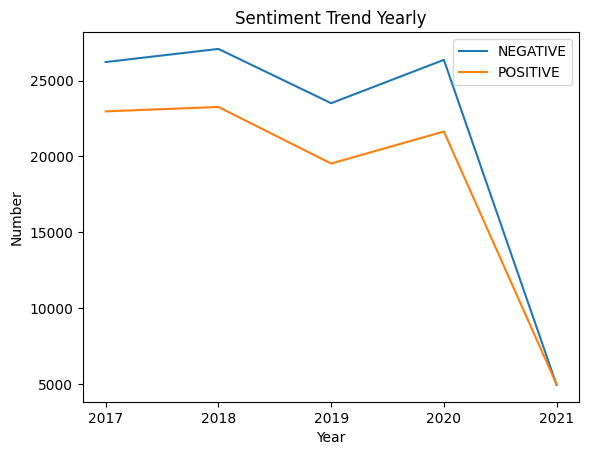

In [10]:
# Plotting the positive and negative headlines per year
df_year = df.groupBy('Year').pivot('sentiment').count().sort('Year').toPandas()
df_year.plot.line(x='Year')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))#set x-axis as integer
plt.xlabel("Year")
plt.ylabel("Number")
plt.title('Sentiment Trend Yearly')
plt.show()

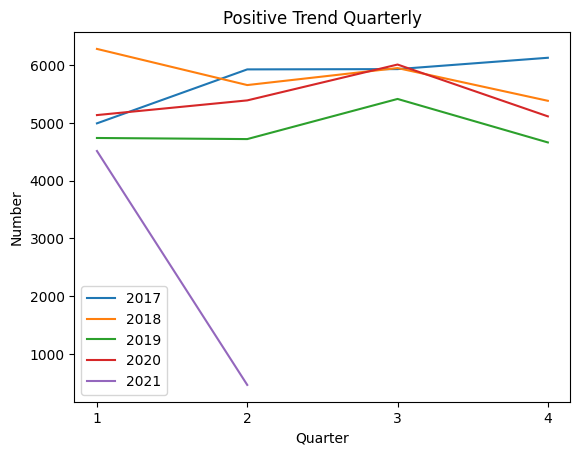

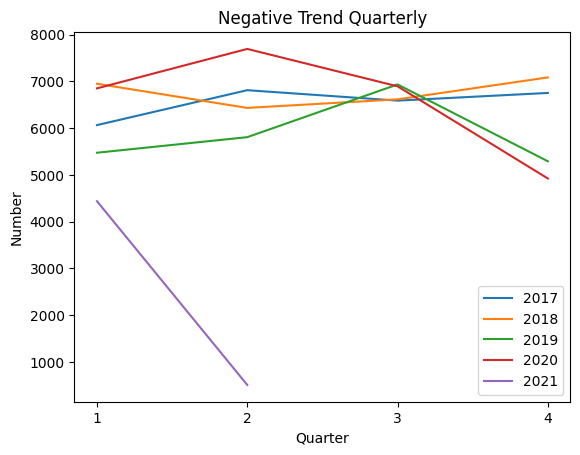

In [11]:
# Splitting the df into positive and negative headlines separately
df_pos = df.filter(col('sentiment')=='POSITIVE') 
df_neg = df.filter(col('sentiment')=='NEGATIVE') 

# Plotting the positive and negative headlines per quarter
# Positive
df_quarter_pos_plt = df_pos.groupBy('Quarter').pivot('Year').count().sort('Quarter').toPandas()
df_quarter_pos_plt.plot(x='Quarter')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))#set x-axis as integer
plt.ylabel("Number")
plt.title('Positive Trend Quarterly')
plt.show()

# Negative
df_quarter_neg_plt = df_neg.groupBy('Quarter').pivot('Year').count().sort('Quarter').toPandas()
df_quarter_neg_plt.plot(x='Quarter')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))#set x-axis as integer
plt.ylabel("Number")
plt.title('Negative Trend Quarterly')
plt.show()

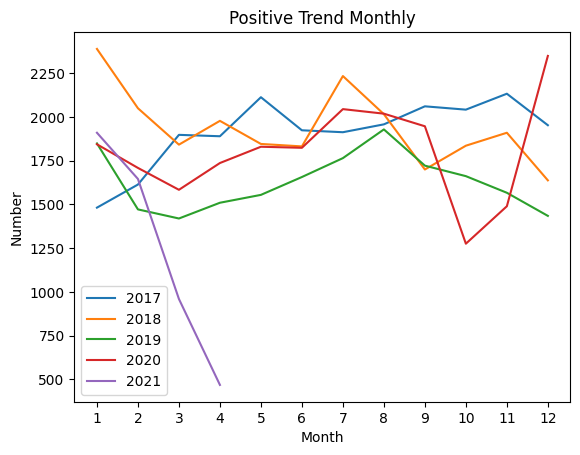

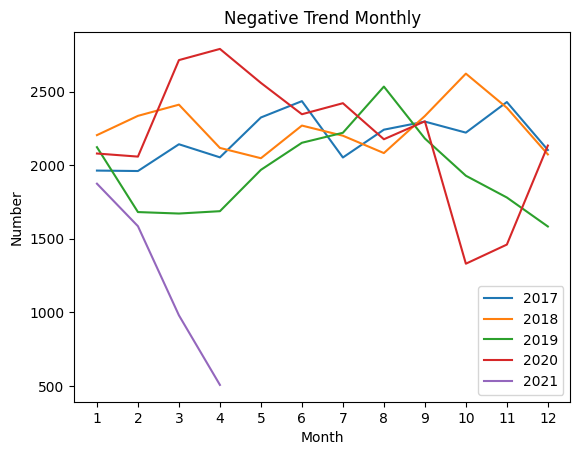

In [12]:
# Plotting the positive and negative headlines per month
# Positive
df_quarter_pos_plt = df_pos.groupBy('Month').pivot('Year').count().sort('Month').toPandas()
df_quarter_pos_plt.plot(x='Month')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))#set x-axis as integer
plt.ylabel("Number")
plt.title('Positive Trend Monthly')
plt.show()

# Negative
df_quarter_neg_plt = df_neg.groupBy('Month').pivot('Year').count().sort('Month').toPandas()
df_quarter_neg_plt.plot(x='Month')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))#set x-axis as integer
plt.ylabel("Number")
plt.title('Negative Trend Monthly')
plt.show()

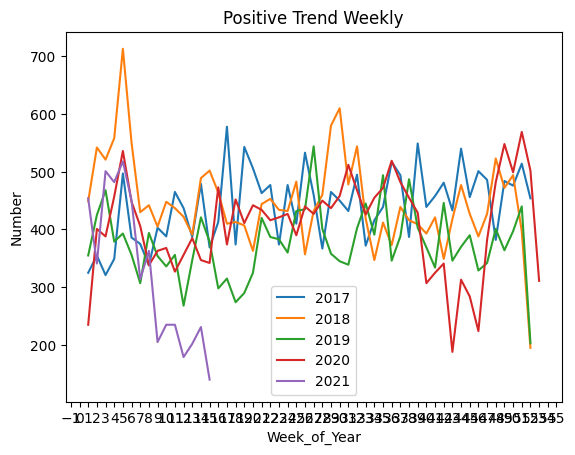

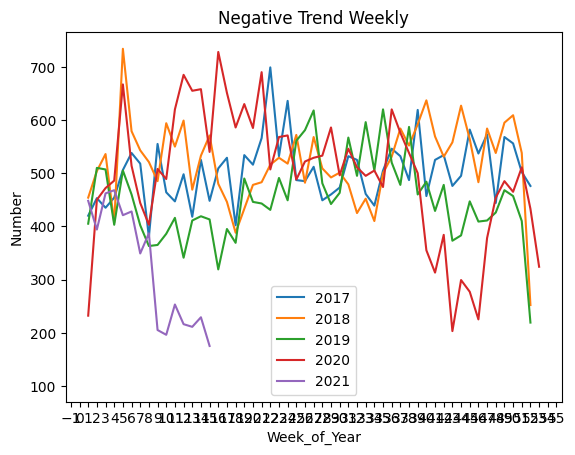

In [13]:
# Plotting the positive and negative headlines per week
# Positive
df_quarter_pos_plt = df_pos.groupBy('Week_of_Year').pivot('Year').count().sort('Week_of_Year').toPandas()
df_quarter_pos_plt.plot(x='Week_of_Year')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))#set x-axis as integer
plt.ylabel("Number")
plt.title('Positive Trend Weekly')
plt.show()

# Negative
df_quarter_neg_plt = df_neg.groupBy('Week_of_Year').pivot('Year').count().sort('Week_of_Year').toPandas()
df_quarter_neg_plt.plot(x='Week_of_Year')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))#set x-axis as integer
plt.ylabel("Number")
plt.title('Negative Trend Weekly')
plt.show()

# Modeling with Machine Learning Algorithms

In [14]:
# Checking the spark dataframe's schema
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Title: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Week_of_Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- intSentiment: integer (nullable = false)



In [15]:
# Indexing the dependent variable (label)
df = df.withColumn('sentiment', regexp_replace('sentiment', 'POSITIVE', '1'))
df = df.withColumn('sentiment', regexp_replace('sentiment', 'NEGATIVE', '0'))
df = df.selectExpr('Title', 'INT(sentiment)')

df.show(2)

+--------------------+---------+
|               Title|sentiment|
+--------------------+---------+
|Eliminating shado...|        1|
|Two Chinese compa...|        0|
+--------------------+---------+
only showing top 2 rows



In [16]:
def modelEvaluation(model, df):

    # Tokenizing the sentences
    tokenizer = RegexTokenizer(inputCol="Title",outputCol="raw_tokens",pattern= "\\W")
    rawTokenizedDF = tokenizer.transform(df)

    # Removing the stopwords
    remover = StopWordsRemover(inputCol="raw_tokens",outputCol="noStop_tokens")
    noStopTokenizedDF = remover.transform(rawTokenizedDF)
    noStopTokenizedDF = noStopTokenizedDF.withColumn('numTokens',size(noStopTokenizedDF['noStop_tokens']))

    # Applying CountVectorizer
    countVectorizer = CountVectorizer(inputCol='noStop_tokens',outputCol='word_features',minDF=3)
    cv_model = countVectorizer.fit(noStopTokenizedDF)
    df_countVectorized = cv_model.transform(noStopTokenizedDF)
    
    # Splitting the data into training and testing
    df_train, df_test = df_countVectorized.randomSplit([0.8,0.2], seed=1234)
    
    # Applying Vector Assembler
    vecAssembler = VectorAssembler(inputCols=['word_features', 'numTokens'],outputCol='features')
    pipeline = Pipeline(stages=[vecAssembler, model])
    model = pipeline.fit(df_train)
    predictions = model.transform(df_test)
    
    # Evaluating results
    evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction",metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    
    return accuracy

In [17]:
# Models & Hyper Parameters definitions
nb_model = NaiveBayes(featuresCol='features', labelCol='sentiment')
rf_model = RandomForestClassifier(featuresCol = 'features', labelCol = 'sentiment',numTrees=20)
lr_model = LogisticRegression(featuresCol='features', labelCol='sentiment',threshold=0.5)
svc_model = LinearSVC(featuresCol = 'features', labelCol = 'sentiment',maxIter=10, regParam=0.1)

# Initializing objects for each model
nb_accuracy = modelEvaluation(nb_model, df)
rf_accuracy = modelEvaluation(rf_model, df)
lr_accuracy = modelEvaluation(lr_model, df)
svc_accuracy = modelEvaluation(svc_model, df)

# Accuracies for each model
print('Naive Bayes:',nb_accuracy)
print('Random Forest:',rf_accuracy)
print('Logistic Regression:',lr_accuracy)
print('SVC:',svc_accuracy)

23/03/27 03:03:20 WARN DAGScheduler: Broadcasting large task binary with size 1650.6 KiB


23/03/27 03:03:23 WARN DAGScheduler: Broadcasting large task binary with size 1629.0 KiB


23/03/27 03:03:23 WARN DAGScheduler: Broadcasting large task binary with size 2010.5 KiB


23/03/27 03:03:29 WARN DAGScheduler: Broadcasting large task binary with size 1646.5 KiB


23/03/27 03:03:31 WARN DAGScheduler: Broadcasting large task binary with size 1646.5 KiB


23/03/27 03:03:33 WARN DAGScheduler: Broadcasting large task binary with size 1873.5 KiB


23/03/27 03:03:45 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/03/27 03:03:48 WARN MemoryStore: Not enough space to cache rdd_491_0 in memory! (computed 285.8 MiB so far)
23/03/27 03:03:48 WARN BlockManager: Persisting block rdd_491_0 to disk instead.
23/03/27 03:04:20 WARN MemoryStore: Not enough space to cache rdd_491_0 in memory! (computed 429.4 MiB so far)


23/03/27 03:04:36 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/03/27 03:04:36 WARN MemoryStore: Not enough space to cache rdd_491_0 in memory! (computed 429.4 MiB so far)


23/03/27 03:04:52 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/03/27 03:04:52 WARN MemoryStore: Not enough space to cache rdd_491_0 in memory! (computed 429.4 MiB so far)


23/03/27 03:05:07 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/03/27 03:05:08 WARN MemoryStore: Not enough space to cache rdd_491_0 in memory! (computed 429.4 MiB so far)


23/03/27 03:05:23 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/03/27 03:05:24 WARN MemoryStore: Not enough space to cache rdd_491_0 in memory! (computed 429.4 MiB so far)


23/03/27 03:05:40 WARN DAGScheduler: Broadcasting large task binary with size 1749.6 KiB


23/03/27 03:05:44 WARN DAGScheduler: Broadcasting large task binary with size 1646.9 KiB


23/03/27 03:05:47 WARN DAGScheduler: Broadcasting large task binary with size 1648.5 KiB


23/03/27 03:05:49 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/03/27 03:05:49 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/03/27 03:05:49 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/03/27 03:05:49 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/03/27 03:05:49 WARN DAGScheduler: Broadcasting large task binary with size 1648.5 KiB
23/03/27 03:05:49 WARN DAGScheduler: Broadcasting large task binary with size 1648.5 KiB


23/03/27 03:05:49 WARN DAGScheduler: Broadcasting large task binary with size 1648.5 KiB
23/03/27 03:05:49 WARN DAGScheduler: Broadcasting large task binary with size 1648.5 KiB
23/03/27 03:05:50 WARN DAGScheduler: Broadcasting large task binary with size 1648.5 KiB
23/03/27 03:05:50 WARN DAGScheduler: Broadcasting large task binary with size 1648.5 KiB
23/03/27 03:05:50 WARN DAGScheduler: Broadcasting large task binary with size 1648.5 KiB
23/03/27 03:05:50 WARN DAGScheduler: Broadcasting large task binary with size 1648.5 KiB
23/03/27 03:05:50 WARN DAGScheduler: Broadcasting large task binary with size 1648.5 KiB
23/03/27 03:05:50 WARN DAGScheduler: Broadcasting large task binary with size 1648.5 KiB
23/03/27 03:05:50 WARN DAGScheduler: Broadcasting large task binary with size 1648.5 KiB
23/03/27 03:05:50 WARN DAGScheduler: Broadcasting large task binary with size 1648.5 KiB
23/03/27 03:05:50 WARN DAGScheduler: Broadcasting large task binary with size 1648.5 KiB
23/03/27 03:05:50 WAR

23/03/27 03:05:57 WARN DAGScheduler: Broadcasting large task binary with size 1648.5 KiB
23/03/27 03:05:57 WARN DAGScheduler: Broadcasting large task binary with size 1648.5 KiB
23/03/27 03:05:57 WARN DAGScheduler: Broadcasting large task binary with size 1648.5 KiB
23/03/27 03:05:57 WARN DAGScheduler: Broadcasting large task binary with size 1648.5 KiB
23/03/27 03:05:57 WARN DAGScheduler: Broadcasting large task binary with size 1844.7 KiB


23/03/27 03:06:01 WARN DAGScheduler: Broadcasting large task binary with size 1646.9 KiB


23/03/27 03:06:03 WARN DAGScheduler: Broadcasting large task binary with size 1648.1 KiB


23/03/27 03:06:06 WARN DAGScheduler: Broadcasting large task binary with size 1648.1 KiB
23/03/27 03:06:06 WARN DAGScheduler: Broadcasting large task binary with size 1648.1 KiB
23/03/27 03:06:06 WARN DAGScheduler: Broadcasting large task binary with size 1648.1 KiB
23/03/27 03:06:06 WARN DAGScheduler: Broadcasting large task binary with size 1648.1 KiB
23/03/27 03:06:06 WARN DAGScheduler: Broadcasting large task binary with size 1648.1 KiB
23/03/27 03:06:06 WARN DAGScheduler: Broadcasting large task binary with size 1648.1 KiB
23/03/27 03:06:06 WARN DAGScheduler: Broadcasting large task binary with size 1648.1 KiB
23/03/27 03:06:06 WARN DAGScheduler: Broadcasting large task binary with size 1648.1 KiB
23/03/27 03:06:06 WARN DAGScheduler: Broadcasting large task binary with size 1648.1 KiB
23/03/27 03:06:06 WARN DAGScheduler: Broadcasting large task binary with size 1648.1 KiB
23/03/27 03:06:06 WARN DAGScheduler: Broadcasting large task binary with size 1648.1 KiB
23/03/27 03:06:06 WAR

Naive Bayes: 0.7413348036390065
Random Forest: 0.5443221974386607
Logistic Regression: 0.7660209017317862
SVC: 0.7762963334252274


# Topic Modeling

In [18]:
# Regex Tokenizer to convert sentences to words
regex_tokenizer = RegexTokenizer(inputCol="Title", outputCol="words", pattern="\\W")
words = regex_tokenizer.transform(df)
words.show(3,truncate=False, vertical=True)

-RECORD 0---------------------------------------------------------------------------------------
 Title     | Eliminating shadow economy to have positive impact on GDP : Arun Jaitley           
 sentiment | 1                                                                                  
 words     | [eliminating, shadow, economy, to, have, positive, impact, on, gdp, arun, jaitley] 
-RECORD 1---------------------------------------------------------------------------------------
 Title     | Two Chinese companies hit roadblock with Indian investments                        
 sentiment | 0                                                                                  
 words     | [two, chinese, companies, hit, roadblock, with, indian, investments]               
-RECORD 2---------------------------------------------------------------------------------------
 Title     | SoftBank India Vision gets new $100                                                
 sentiment | 1                

In [19]:
# Removing stopwords
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filteredWords")
remover_df = stopwords_remover.transform(words)
remover_df.show(3,truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------
 Title         | Eliminating shadow economy to have positive impact on GDP : Arun Jaitley           
 sentiment     | 1                                                                                  
 words         | [eliminating, shadow, economy, to, have, positive, impact, on, gdp, arun, jaitley] 
 filteredWords | [eliminating, shadow, economy, positive, impact, gdp, arun, jaitley]               
-RECORD 1-------------------------------------------------------------------------------------------
 Title         | Two Chinese companies hit roadblock with Indian investments                        
 sentiment     | 0                                                                                  
 words         | [two, chinese, companies, hit, roadblock, with, indian, investments]               
 filteredWords | [two, chinese, companies, hit, roadblock, indian, investments]            

In [20]:
# Applying Count Vectorizer
count_vect = CountVectorizer(inputCol="filteredWords", outputCol="rawFeatures", vocabSize=150, minDF=2)
cv_model = count_vect.fit(remover_df)
vectorized_df = cv_model.transform(remover_df)
vectorized_df.show(3,truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------
 Title         | Eliminating shadow economy to have positive impact on GDP : Arun Jaitley           
 sentiment     | 1                                                                                  
 words         | [eliminating, shadow, economy, to, have, positive, impact, on, gdp, arun, jaitley] 
 filteredWords | [eliminating, shadow, economy, positive, impact, gdp, arun, jaitley]               
 rawFeatures   | (150,[13,74,103],[1.0,1.0,1.0])                                                    
-RECORD 1-------------------------------------------------------------------------------------------
 Title         | Two Chinese companies hit roadblock with Indian investments                        
 sentiment     | 0                                                                                  
 words         | [two, chinese, companies, hit, roadblock, with, indian, investments]      

In [21]:
# Initializing Latent Dirichlet Allocation (LDA) model with 10 topics 
lda = LDA(k=10, maxIter=10, seed=1234, featuresCol="rawFeatures")
lda_model = lda.fit(vectorized_df)
lda_model

LocalLDAModel: uid=LDA_0d2e77cd4f9a, k=10, numFeatures=150

In [22]:
# Log Likelihood measures how well the model fits the data
log_likelihood = lda_model.logLikelihood(vectorized_df)
log_perplexity = lda_model.logPerplexity(vectorized_df)
print("Log Likelihood:", log_likelihood)
print("Log Perplexity:", log_perplexity)

Log Likelihood: -2964486.574097314
Log Perplexity: 4.9024573984483295


In [23]:
# Generating topics for the corpus (dataset) along with their term weights
topics = lda_model.describeTopics()
topics.show(5,truncate=False, vertical=True)

-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 topic       | 0                                                                                                                                                                                                                     
 termIndices | [2, 27, 22, 35, 58, 73, 70, 25, 44, 28]                                                                                                                                                                               
 termWeights | [0.1100114567620489, 0.05822004455599651, 0.05036266292560406, 0.04185535379274684, 0.037662581152170145, 0.03442266312576006, 0.03256136478399784, 0.029022547990901947, 0.028187584550990647, 0.026592168963476156] 
-RECORD 1-----------------------------------------------------------------------

In [24]:
# Defining User Defined Function to get the words in each topic from the vocabulary
vocab = cv_model.vocabulary
def get_words(index_list):
  return [vocab[index_id] for index_id in index_list]

index_to_words = udf(get_words)

topics = lda_model.describeTopics().withColumn("topicWords", index_to_words(col("termIndices")))
topics.select("topic", "topicWords").show(truncate=False)

+-----+-------------------------------------------------------------------------------+
|topic|topicWords                                                                     |
+-----+-------------------------------------------------------------------------------+
|0    |[rs, crore, gold, prices, fund, mutual, funds, 1, 000, oil]                    |
|1    |[india, modi, business, pm, 2017, finance, narendra, billion, china, first]    |
|2    |[market, stock, live, news, price, sebi, share, buy, sell, ltd]                |
|3    |[rbi, covid, 19, policy, rate, cut, banks, sector, rates, inflation]           |
|4    |[stocks, sensex, nifty, bank, markets, 10, top, shares, street, market]        |
|5    |[budget, says, new, tax, may, coronavirus, economic, govt, 1, investors]       |
|6    |[indian, trump, economy, donald, fed, sales, us, data, 8, 2]                   |
|7    |[rupee, us, global, dollar, year, oil, trade, capital, crude, million]         |
|8    |[china, trade, us, deal, 

In [25]:
topics_per_documents = lda_model.transform(vectorized_df)
topics_per_documents.select("words", "topicDistribution").show(5,truncate=False, vertical=True)

-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 words             | [eliminating, shadow, economy, to, have, positive, impact, on, gdp, arun, jaitley]                                                                                                                            
 topicDistribution | [0.025137927085315606,0.025194200681101033,0.02489889938059036,0.2181577281554666,0.02515722393776504,0.02533971886636761,0.024639864387606358,0.02484965169733571,0.024246132324897706,0.582378653483554]    
-RECORD 1--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 words             | [two, chinese, companies, hit, roadblock, with, indian, investments

In [26]:
spark.stop()